# Imports

In [1]:
import pickle
import json
from __future__ import division
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from numpy.random import randint
from numpy.random import rand
import multiprocessing as mp
import random
import math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.layers import Input,Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM,Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,UpSampling1D, Conv1DTranspose,GaussianNoise 
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback
from keras.regularizers import l2 , l1, l1_l2
import tensorflow.keras.backend as kb
print('keras version ', keras.__version__)

from keras.utils.vis_utils import plot_model

keras version  2.9.0


In [2]:
sys.path.append("../src")
from convertor import convert
from preprocessing import get_target, preprocessing

In [3]:
from imblearn.under_sampling import RandomUnderSampler

# Functions

In [4]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [5]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [6]:
class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [7]:
def confusion_matrix(validations, predictions, LABELS):            
    freq = metrics.confusion_matrix(validations, predictions)        
    sensitivity =  (np.divide(freq.transpose(),
                             np.sum(freq, axis=1)).transpose() * 100).round(2)    
    annotation = []
    for i in range(freq.shape[0]):
        row = []
        for j in range(freq.shape[1]):
            row.append(f'{freq[i][j]}\n {sensitivity[i][j]}%')            
        annotation.append(row)
    annotation = np.array(annotation)
    sns.heatmap(sensitivity, cmap="YlOrBr",
                vmin=0, vmax=100,
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=annotation,
               fmt=':<')    
    plt.title("Confusion Matrix")
    plt.ylabel("Actually Label")
    plt.xlabel("Predicted Label")
    plt.show()            

def report(pred, df, ref):
    number_of_hit = len(df['hit seq'].unique())
    print(f'number of unique hit: {number_of_hit}')
    total = len(df[df['hit seq'].isin(ref['data'])]['hit seq'].unique()) 
    print(f'total mir: {total}')    
    selected = df[pd.Series(pred).apply(lambda x: True if x==1 else False)]
    found_seq = selected[selected['hit seq'].isin(ref['data'])]['hit seq'].unique()
    found = len(found_seq)
    print(f'found mir : {found}')
    print(f'fount to all : {round(found / total * 100, 2)}%')
    fp = len(selected[~selected['hit seq'].isin(ref['data'])]['hit seq'].unique())
    print(f'fp: {fp}')

# Load all plant dataset

In [8]:
all_plant = [
    "O.sativa",
    "A.thaliana",
    "C.sinensis",
    "Z.mays",
    "T.aestivum",
    "G.max",
    "G.raimondii",
    "M.truncatula",
    "S.bicolor"    
]

In [9]:
data = {}

In [10]:
def get_load(plant, mu=None, std=None):    
    posX = pd.read_csv(f"../Experiment/{plant}/positive/Result/result_level1_filter.csv")
    precursor_pos = pd.Series(list(posX['precursor seq'].unique()))
    posy = np.ones(precursor_pos.shape[0], dtype='float32')
    posy = np_utils.to_categorical(posy, 2)
    posX = convert(posX)    
    posY = np.ones(posX.shape[0], dtype='float32')
    posY = np_utils.to_categorical(posY, 2)    
    
    negX = pd.read_csv(f"../Experiment/{plant}/negative/Result/result_level1_filter.csv")
    precursor_neg = pd.Series(list(negX['precursor seq'].unique()))
    negy = np.zeros(precursor_neg.shape[0], dtype='float32')
    negy = np_utils.to_categorical(negy, 2)
    negX = convert(negX)    
    negY = np.zeros(negX.shape[0], dtype='float32')
    negY = np_utils.to_categorical(negY, 2)                
    
    Y = np.concatenate([posY, negY])            
    X = pd.concat([posX, negX]).reset_index(drop=True)    
    y = np.concatenate([posy, negy])
    precursor = pd.concat([precursor_pos, precursor_neg]).reset_index(drop=True)
    rus = RandomUnderSampler(random_state=0)  
    precursor, y = rus.fit_resample(pd.DataFrame(precursor) , y)
            
    # for negative
    #fasta = ""    
    #counter = 0
    #for seq in precursor[y == 0][0]:        
    #    counter += 1
    #    fasta += f">{counter}\n{seq}\n"                    
    #with open(f"../../plantmirp2/{plant}_negative_precursor.fasta", "w") as file:
    #    file.write(fasta)
        
    # for positive
    #fasta = ""        
    #for seq in precursor[y == 1][0]:
    #    counter += 1
    #    fasta += f">{counter}\n{seq}\n"    
    #with open(f"../../plantmirp2/{plant}_positive_precursor.fasta", "w") as file:
    #    file.write(fasta)
    
    index = X['precursor seq'].isin(precursor[0])
    X = X[index].reset_index(drop=True)    
    Y = Y[index,:]
    [feature, mu, std] = preprocessing(X, mu, std)     
    feature.columns = [str(i) for i in feature.columns]
    data[plant] = {}                    
    #Y = np_utils.to_categorical(Y, 2) 
    data[plant]['df'] = X
    data[plant]['feature'] = feature
    data[plant]['target'] = Y
    print(f'total data: {feature.shape[0]}')
    return [X, feature, Y, mu, std]

def load(plant, mu=None, std=None):
    global data
    data[plant] = {}        
    [X, feature, Y, mu, std] = get_load(plant, mu, std)
    data[plant]['df'] = X
    data[plant]['feature'] = feature
    data[plant]['target'] = Y
    return [mu, std]

In [11]:
with open('../classifier/mu.pickle', 'rb') as handle:
    mu = pickle.load(handle)
with open('../classifier/std.pickle', 'rb') as handle:
    std = pickle.load(handle)

## O.sativa

In [12]:
load(plant="O.sativa", mu=mu, std=std);

total data: 2251


## A.thaliana

In [13]:
load(plant="A.thaliana", mu=mu, std=std);

total data: 1271


## C.sinensis

In [14]:
load(plant="C.sinensis", mu=mu, std=std);

total data: 898


## Z.mays

In [15]:
load(plant="Z.mays", mu=mu, std=std);

total data: 964


## T.aestivum

In [16]:
load(plant="T.aestivum", mu=mu, std=std);

total data: 662


## G.max

In [17]:
load(plant="G.max", mu=mu, std=std);

total data: 1795


## G.raimondii

In [18]:
load(plant="G.raimondii", mu=mu, std=std);

total data: 1204


## M.truncatula

In [19]:
load(plant="M.truncatula", mu=mu, std=std);

total data: 1651


## S.bicolor

In [20]:
load(plant="S.bicolor", mu=mu, std=std);

total data: 814


# Train Test split and class weight

In [21]:
def get_dataset(plant_list, val_size=0.33, random_state=0):
    x_list = []
    y_list = []
    for plant in plant_list:
        x_list.append(data[plant]['feature'])
        y_list.append(data[plant]['target'])
    X = pd.concat(x_list)
    Y = np.concatenate(y_list)
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=val_size, random_state=random_state)
    class_weight = {
        0: 1.,
        1: (sum(y_train[:,0]) + sum(y_val[:,0])) / (sum(y_train[:,1]) + sum(y_val[:,1]))
    }        
    return [X_train, X_val, y_train, y_val, class_weight]    

# Deep learning model

In [22]:
def get_model(input_dimension, show=False):    
    model = Sequential()
    model.add(Input(shape=(input_dimension,)))            
    model.add(Dense(512, activation='selu'))    
    model.add(BatchNormalization())
    model.add(Dropout(0.85))    
    model.add(Dense(256, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.85))    
    model.add(Dense(128, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.75))    
    model.add(Dense(64, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))    
    model.add(Dense(32, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))    
    model.add(Dense(16, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))     
    model.add(Dense(8, activation='selu'))        
    model.add(BatchNormalization())
    model.add(Dropout(0.25))     
    model.add(Dense(2, activation='softmax'))
    if(show):
        print(model.summary())
    return model    

In [23]:
def train(model, x_train, x_val, y_train, y_val, class_weight, batch_size, learning_rate,  epochs = 100, save=False):
    callbacks_list = [
                      tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, restore_best_weights=True),
                     ]    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1000,
        decay_rate=0.99)
    
    optimizer = tf.keras.optimizers.Adam(lr_schedule)    

    model.compile(loss = "categorical_crossentropy",                
                  optimizer=optimizer,
                  metrics = ["acc"])
    epochs = 100    
    history = model.fit(x_train,
                        y_train,
                        class_weight=class_weight,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        callbacks=callbacks_list,
                        use_multiprocessing=True,
                        verbose=0) 
    if(save):
        json.dump(str(history.history), open(f"./history.pkl", "w"))
        model.save(f'./Model.h5')
    return [model, history]

In [24]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.plot(history.history['acc'], linewidth=3)
    plt.plot(history.history['val_acc'], linewidth=3)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(history.history['loss'], linewidth=3)
    plt.plot(history.history['val_loss'], linewidth=3)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

# Evaluation

In [54]:
def evaluation(plant):
    y_true = np.argmax(data[plant]['target'], axis=1)
    y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
    confusion_matrix(y_true,y_pred,["No","YES"])
    print(classification_report(y_true, y_pred))

In [55]:
def leave_one_out(plants, batch_size, learning_rate, epochs):
    result = {}
    for i in range(0, len(plants)):
        test_plant = plants[i]
        train_plants = plants.copy()
        train_plants.remove(test_plant)            
        [x_train, x_val, y_train, y_val, class_weight] = get_dataset(train_plants)        
        model = get_model(x_train.shape[1])
        [model, history] = train(model, x_train, x_val, y_train, y_val, class_weight, batch_size = batch_size , learning_rate = learning_rate, epochs=epochs)        
        
        precursor = data[test_plant]['df']['precursor seq']
        all_pred = np.argmax(model.predict(data[test_plant]['feature'], verbose=0), axis=1)
        y_true = []
        y_pred = []
        for prc in tqdm(precursor):    
            indexs = data[test_plant]['df']['precursor seq'] == prc
            feature = data[test_plant]['feature'][indexs]        
            target = data[test_plant]['target'][indexs][0,:][1]            
            y_true.append(target)
            pred = all_pred[indexs]
            y_pred.append(max(pred))        
        tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
        result[test_plant] = {
            "accuracy": metrics.accuracy_score(y_true, y_pred),
            "precision": metrics.precision_score(y_true, y_pred),
            "recall": metrics.recall_score(y_true, y_pred),
            "specificity": tn / (tn+fp),            
            "f1": metrics.f1_score(y_true, y_pred),
            "mcc": metrics.matthews_corrcoef(y_true, y_pred),            
            "model": model,
            "history": history
        }
    return result

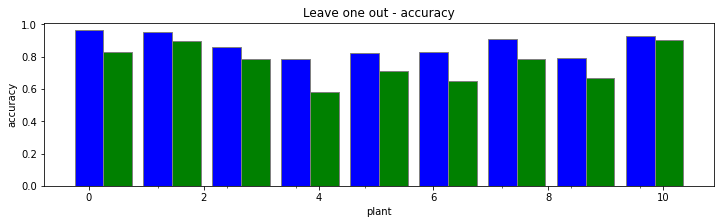

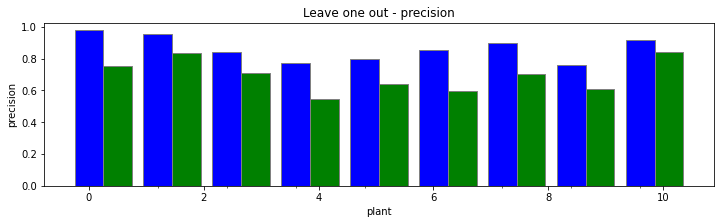

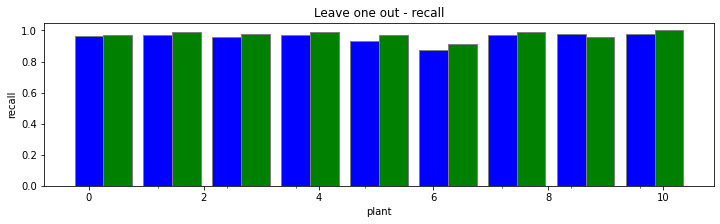

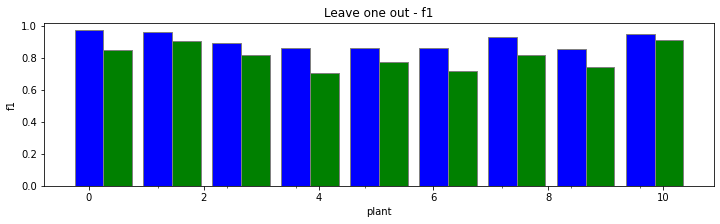

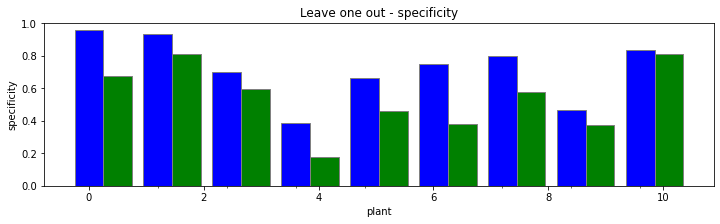

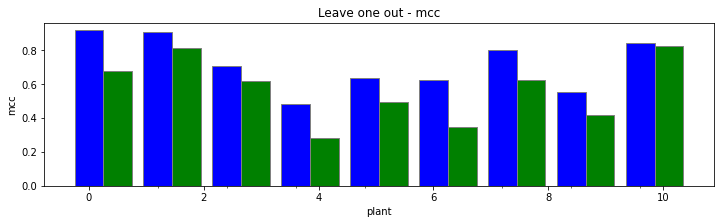

In [76]:
def plot_metrics(result1, result2, plants, prefix_name=""):
    for metric in ['accuracy', 'precision', 'recall', 'f1', "specificity", "mcc"]:
        fig, ax = plt.subplots(figsize=(12, 3))    
        y1 = [result1[plant][metric] for plant in plants]
        y2 = [result2[plant][metric] for plant in plants]
        br1 = np.arange(len(y1)) * 1.2
        br2 = [x + 0.5 for x in br1]
        ax.bar(br1, y1, width = 0.5, color ='b',edgecolor ='grey', label ='our')
        ax.bar(br2, y2, width = 0.5, color ='g',edgecolor ='grey', label ='mirplanp2')
        ax.set_xticks(br1, ["$\it{" + p + "}$" for p in plants]) 
        plt.title(f"Leave one out - {metric}")
        plt.xlabel("plant")
        plt.ylabel(metric)
        plt.
        #for i, v in enumerate(y1):
        #    ax.text(i - 0.2 , v - 0.1, str(round(v, 2)), color='black', fontweight='bold')
        #for i, v in enumerate(y2):
        #    ax.text(i - 0.2 , v - 0.1, str(round(v, 2)), color='black', fontweight='bold')
        plt.savefig(os.path.join(f'../Result/{prefix_name}_leave_one_out_{metric}.svg'), dpi=300, format='svg', bbox_inches='tight')        
        plt.show()
        
plot_metrics(all_result, plantmirp2_result, ['A.thaliana', 'C.sinensis', 'G.max', 'G.raimondii', 'M.truncatula', 'O.sativa', 'S.bicolor', 'T.aestivum', 'Z.mays'], prefix_name="")

#  leave one out

In [ ]:
all_result = leave_one_out(all_plant, batch_size=32, learning_rate = 0.002, epochs=500)

  0%|          | 0/2251 [00:00<?, ?it/s]

  0%|          | 0/1271 [00:00<?, ?it/s]

  0%|          | 0/898 [00:00<?, ?it/s]

In [64]:
plantmirp2_result = {}
for plant in tqdm(all_plant):
    pos_pred = pd.read_csv(f"./plantmirp2_result/{plant}_positive_precursor.fasta_results.txt")['predict_type']        
    pos_target = np.ones(pos_pred.shape[0], dtype='float32')
    neg_pred = pd.read_csv(f"./plantmirp2_result/{plant}_negative_precursor.fasta_results.txt")['predict_type']
    neg_target = np.zeros(neg_pred.shape[0], dtype='float32')
    y_true = np.concatenate([pos_target, neg_target])
    y_pred = np.concatenate([pos_pred, neg_pred])
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    plantmirp2_result[plant] = {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "precision": metrics.precision_score(y_true, y_pred),
        "recall": metrics.recall_score(y_true, y_pred),
        "specificity": tn / (tn+fp),            
        "f1": metrics.f1_score(y_true, y_pred),
        "mcc": metrics.matthews_corrcoef(y_true, y_pred)        
    }    

  0%|          | 0/9 [00:00<?, ?it/s]

In [95]:
for plant in all_result:
    temp = all_result[plant]
    temp2 = plantmirp2_result[plant]
    print(f"{plant}")
    print(f"accuracy:    {round(temp['accuracy'], 5)}, {round(temp2['accuracy'], 5)}")
    print(f"precision:   {round(temp['precision'], 5)}, {round(temp2['precision'], 5)}")
    print(f"recall:      {round(temp['recall'], 5)}, {round(temp2['recall'], 5)}")
    print(f"specificity: {round(temp['specificity'], 5)}, {round(temp2['specificity'], 5)}")
    print(f"f1:          {round(temp['f1'], 5)}, {round(temp2['f1'], 5)}")
    print(f"mcc:         {round(temp['mcc'], 5)}, {round(temp2['mcc'], 5)}")
    print()
    print()

O.sativa
accuracy:    0.82674, 0.64627
precision:   0.85606, 0.59514
recall:      0.87174, 0.91494
specificity: 0.75, 0.37759
f1:          0.86383, 0.72118
mcc:         0.62598, 0.34686


A.thaliana
accuracy:    0.96223, 0.82593
precision:   0.9773, 0.75676
recall:      0.96576, 0.97222
specificity: 0.95519, 0.67273
f1:          0.9715, 0.85106
mcc:         0.9157, 0.67922


C.sinensis
accuracy:    0.95546, 0.89835
precision:   0.9562, 0.83721
recall:      0.97037, 0.98901
specificity: 0.93296, 0.80769
f1:          0.96324, 0.9068
mcc:         0.9069, 0.81013


Z.mays
accuracy:    0.92842, 0.90452
precision:   0.91742, 0.83966
recall:      0.9776, 1.0
specificity: 0.83776, 0.80905
f1:          0.94655, 0.91284
mcc:         0.84245, 0.82421


T.aestivum
accuracy:    0.79154, 0.66883
precision:   0.76155, 0.60656
recall:      0.97862, 0.96104
specificity: 0.46473, 0.37662
f1:          0.85655, 0.74372
mcc:         0.55196, 0.41612


G.max
accuracy:    0.86072, 0.78589
precision:   0.8392

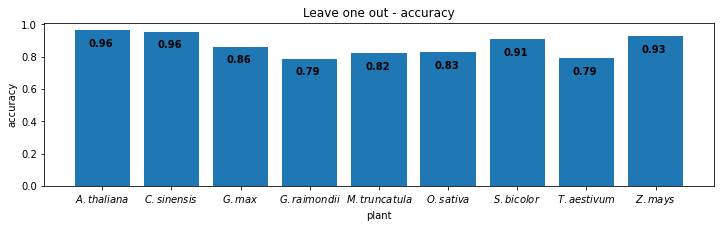

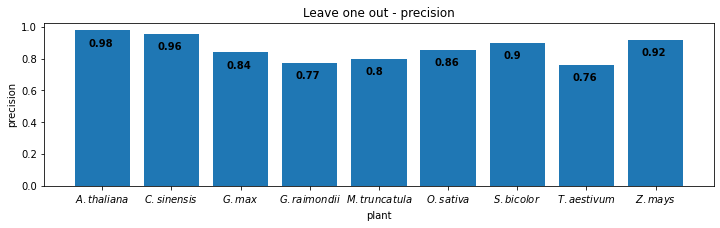

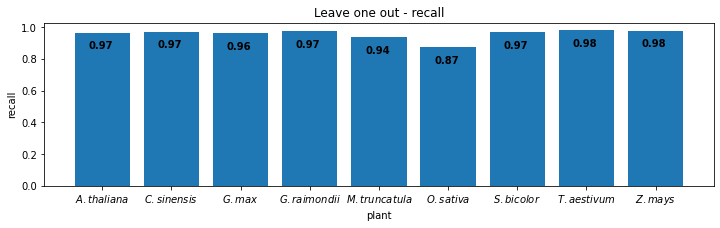

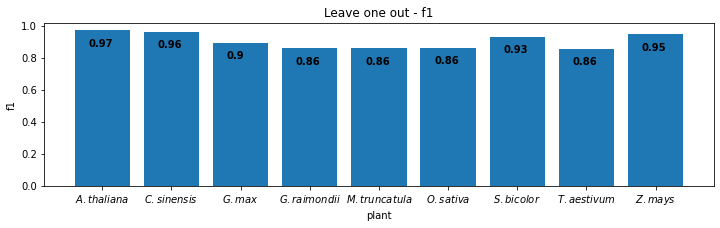

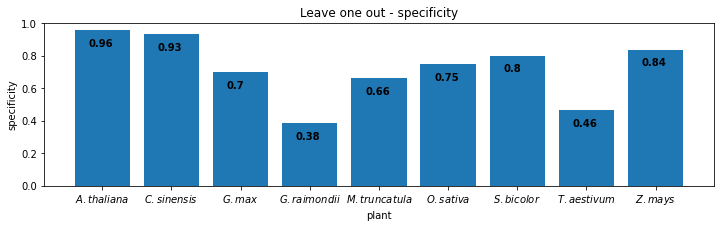

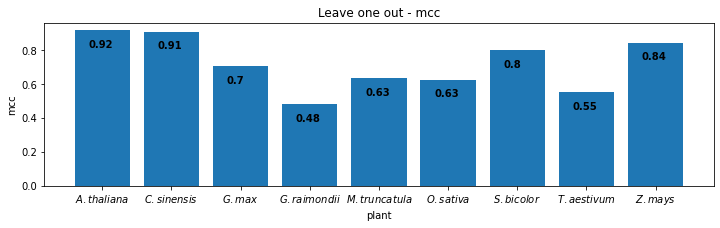

In [61]:
plot_metrics(all_result, plantmirp2_result, ['A.thaliana', 'C.sinensis', 'G.max', 'G.raimondii', 'M.truncatula', 'O.sativa', 'S.bicolor', 'T.aestivum', 'Z.mays'], prefix_name="")

40/40 [==============================] - 0s 4ms/step


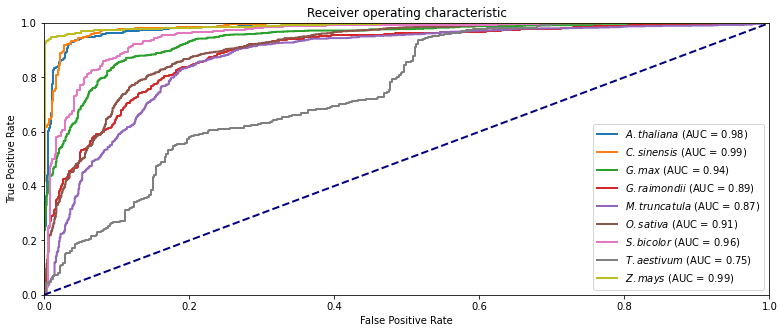

In [130]:
plt.figure(figsize=(13,5))
for plant in ['A.thaliana', 'C.sinensis', 'G.max', 'G.raimondii', 'M.truncatula', 'O.sativa', 'S.bicolor', 'T.aestivum', 'Z.mays']:
    pred = all_result[plant]['model'].predict(data[plant]['feature'])
    pred = pd.DataFrame(pred)[1]
    y =  data[plant]['target']
    y = pd.DataFrame(y)[1]
    fpr, tpr, thresh = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)    
    lw = 2
    plt.plot(
        fpr,
        tpr,        
        lw=lw,
        label="$\it{" + plant + "}$" + " (AUC = %0.2f)" % roc_auc,
    )    
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig(os.path.join(f'../Result/ROC.svg'), dpi=300, format='svg', bbox_inches='tight')        
plt.show()

# monocotiledoneas vs dicotiledoneas

In [245]:
monocotiledoneas = [
    "O.sativa",        
    "Z.mays",
    "T.aestivum",            
    "S.bicolor",
    "H.vulgare"
]

mono_result = leave_one_out(monocotiledoneas)

326
Epoch 1/100
286/286 [==============================] - 4s 7ms/step - loss: 0.6980 - acc: 0.8232 - val_loss: 0.0970 - val_acc: 0.9676
Epoch 2/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2944 - acc: 0.9490 - val_loss: 0.1079 - val_acc: 0.9665
Epoch 3/100
286/286 [==============================] - 2s 6ms/step - loss: 0.1710 - acc: 0.9678 - val_loss: 0.0553 - val_acc: 0.9798
Epoch 4/100
286/286 [==============================] - 2s 6ms/step - loss: 0.1503 - acc: 0.9756 - val_loss: 0.0452 - val_acc: 0.9842
Epoch 5/100
286/286 [==============================] - 2s 6ms/step - loss: 0.1080 - acc: 0.9836 - val_loss: 0.0728 - val_acc: 0.9758
Epoch 6/100
286/286 [==============================] - 2s 6ms/step - loss: 0.1143 - acc: 0.9828 - val_loss: 0.0376 - val_acc: 0.9880
Epoch 7/100
286/286 [==============================] - 2s 6ms/step - loss: 0.0812 - acc: 0.9860 - val_loss: 0.0304 - val_acc: 0.9918
Epoch 8/100
286/286 [==============================] - 2s 6ms/ste

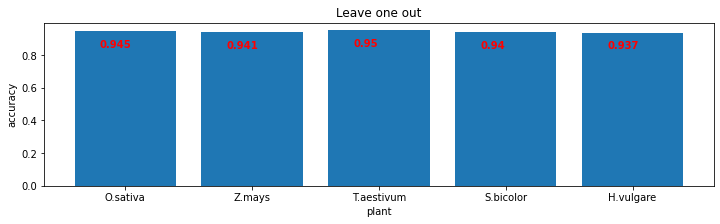

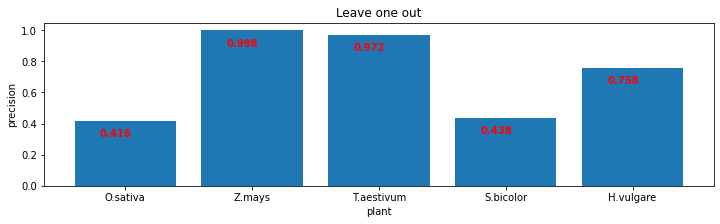

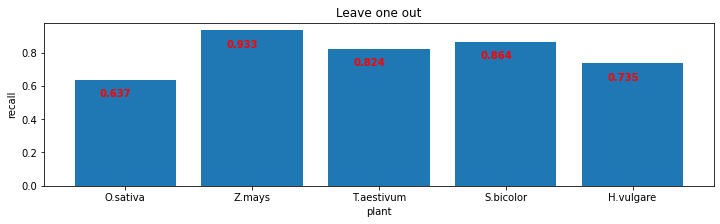

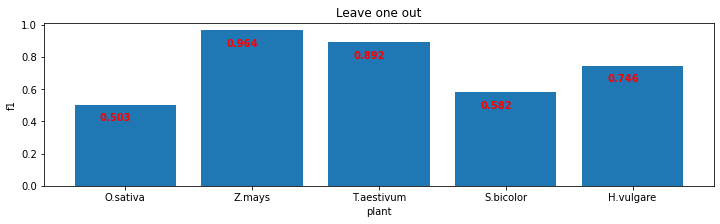

In [246]:
plot_metrics(mono_result, monocotiledoneas, prefix_name="")

In [ ]:
dicotiledoneas = [    
    "A.thaliana",
    "C.Sinensis",        
    "G.max",
    "G.raimondii",
    "M.truncatula"    
]
di_result = leave_one_out(dicotiledoneas)

## O.sativa

1010/1010 [==============================] - 2s 2ms/step


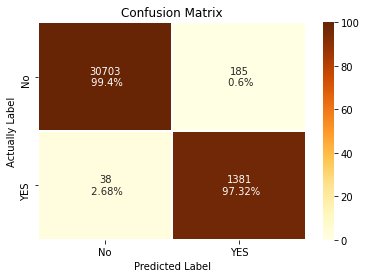

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     30888
           1       0.88      0.97      0.93      1419

    accuracy                           0.99     32307
   macro avg       0.94      0.98      0.96     32307
weighted avg       0.99      0.99      0.99     32307



In [178]:
evaluation('O.sativa')

## A.thaliana

350/350 [==============================] - 1s 2ms/step


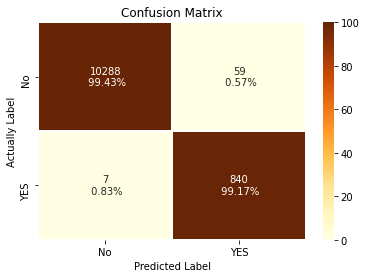

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10347
           1       0.93      0.99      0.96       847

    accuracy                           0.99     11194
   macro avg       0.97      0.99      0.98     11194
weighted avg       0.99      0.99      0.99     11194



In [179]:
evaluation('A.thaliana')

350/350 [==============================] - 1s 2ms/step


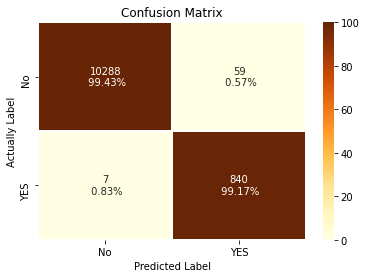

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10347
           1       0.93      0.99      0.96       847

    accuracy                           0.99     11194
   macro avg       0.97      0.99      0.98     11194
weighted avg       0.99      0.99      0.99     11194



In [180]:
plant = 'A.thaliana'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
print(classification_report(y_true, y_pred))

## C.Sinensis

70/70 [==============================] - 0s 2ms/step


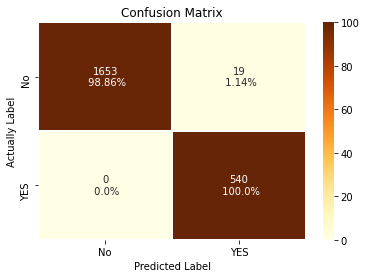

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1672
           1       0.97      1.00      0.98       540

    accuracy                           0.99      2212
   macro avg       0.98      0.99      0.99      2212
weighted avg       0.99      0.99      0.99      2212



In [181]:
evaluation('C.Sinensis')

## Z.mays

23/23 [==============================] - 0s 2ms/step


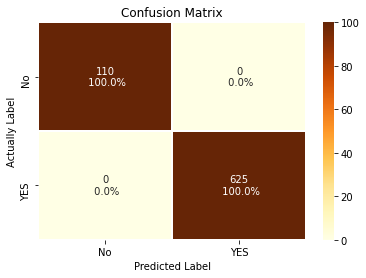

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       625

    accuracy                           1.00       735
   macro avg       1.00      1.00      1.00       735
weighted avg       1.00      1.00      1.00       735



In [182]:
evaluation('Z.mays')

## T.aestivum

53/53 [==============================] - 0s 2ms/step


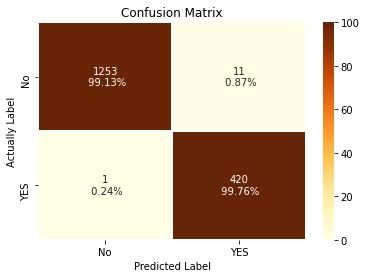

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1264
           1       0.97      1.00      0.99       421

    accuracy                           0.99      1685
   macro avg       0.99      0.99      0.99      1685
weighted avg       0.99      0.99      0.99      1685



In [183]:
evaluation('T.aestivum')

## G.max

993/993 [==============================] - 2s 2ms/step


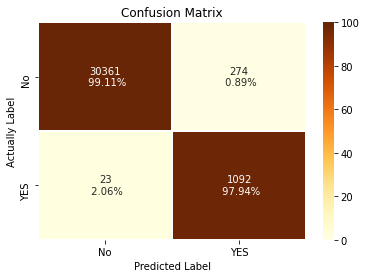

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     30635
           1       0.80      0.98      0.88      1115

    accuracy                           0.99     31750
   macro avg       0.90      0.99      0.94     31750
weighted avg       0.99      0.99      0.99     31750



In [184]:
evaluation('G.max')

## G.raimondii

689/689 [==============================] - 2s 2ms/step


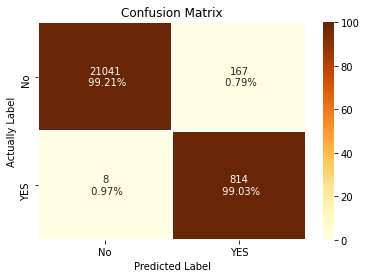

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     21208
           1       0.83      0.99      0.90       822

    accuracy                           0.99     22030
   macro avg       0.91      0.99      0.95     22030
weighted avg       0.99      0.99      0.99     22030



In [185]:
evaluation('G.raimondii')

## M.truncatula

426/426 [==============================] - 1s 2ms/step


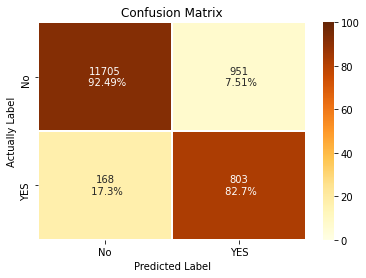

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     12656
           1       0.46      0.83      0.59       971

    accuracy                           0.92     13627
   macro avg       0.72      0.88      0.77     13627
weighted avg       0.95      0.92      0.93     13627



In [186]:
evaluation('M.truncatula')

# Confusion matrix

9/9 [==============================] - 0s 3ms/step


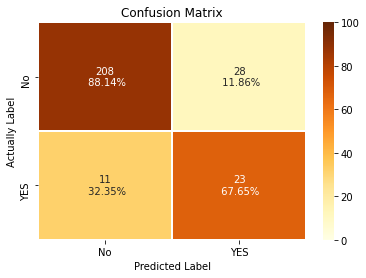

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       236
           1       0.45      0.68      0.54        34

    accuracy                           0.86       270
   macro avg       0.70      0.78      0.73       270
weighted avg       0.89      0.86      0.87       270



In [191]:
evaluation('H.vulgare')

In [34]:
208 / (208 + 28)

0.8813559322033898

# final model

In [112]:
train_plants = all_plant.copy()        
[x_train, x_val, y_train, y_val, class_weight] = get_dataset(train_plants)        
print(class_weight)
model = get_model(x_train.shape[1])
[model, history] = train(model, x_train, x_val, y_train, y_val, class_weight,  batch_size=32, learning_rate = 0.002, epochs=500)                

{0: 1.0, 1: 1.0}


In [113]:
model.save('../classifier/model.h5')  